In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import optim
import matplotlib.pyplot as plt

In [36]:
#importing cifar10 dataset
train_dataset = datasets.CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=transforms.ToTensor())

#dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

Files already downloaded and verified


In [39]:
#defining convolution block
class convl(nn.Module):
    def __init__(self, in_channels, out_channels, activation='leaky_relu'):
        super(convl, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        if activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        return x

In [44]:
#defining the model
class greedyModel(nn.Module):
    def __init__(self):
        super(greedyModel, self).__init__()
        self.conv1 = convl(3, 32, activation='elu')
        self.conv2 = convl(32, 64, activation='leaky_relu')
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [58]:
#Greedy training class
class greedy_train:
    def __init__(self, model, trainloader, optimizer, criterion, num_epochs=15):
        self.model = model
        self.trainloader = trainloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.block_losses = []  #Stores losses for each block

    def train_block(self, block):
        for flag in self.model.parameters():
            flag.requires_grad = False
        for flag in block.parameters():
            flag.requires_grad = True

        block_loss = []
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for i, (images, labels) in enumerate(self.trainloader):
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % len(self.trainloader) == len(self.trainloader) - 1:
                    average_loss = running_loss / len(self.trainloader)
                    print(f'[Epoch {epoch + 1}], loss: {average_loss:.3f}')
                    block_loss.append(average_loss)
                    running_loss = 0.0

        self.block_losses.append(block_loss)

    def train(self):
        for block in [self.model.conv1, self.model.conv2]:
            self.train_block(block)

In [59]:
model = greedyModel()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


training = greedy_train(model, train_loader, optimizer, criterion)
training.train()

[Epoch 1], loss: 2.295
[Epoch 2], loss: 2.276
[Epoch 3], loss: 2.263
[Epoch 4], loss: 2.253
[Epoch 5], loss: 2.242
[Epoch 6], loss: 2.233
[Epoch 7], loss: 2.225
[Epoch 8], loss: 2.217
[Epoch 9], loss: 2.210
[Epoch 10], loss: 2.204
[Epoch 11], loss: 2.198
[Epoch 12], loss: 2.192
[Epoch 13], loss: 2.187
[Epoch 14], loss: 2.182
[Epoch 15], loss: 2.177
[Epoch 1], loss: 2.072
[Epoch 2], loss: 2.037
[Epoch 3], loss: 2.020
[Epoch 4], loss: 2.011
[Epoch 5], loss: 2.003
[Epoch 6], loss: 1.996
[Epoch 7], loss: 1.988
[Epoch 8], loss: 1.982
[Epoch 9], loss: 1.976
[Epoch 10], loss: 1.969
[Epoch 11], loss: 1.965
[Epoch 12], loss: 1.961
[Epoch 13], loss: 1.958
[Epoch 14], loss: 1.955
[Epoch 15], loss: 1.950


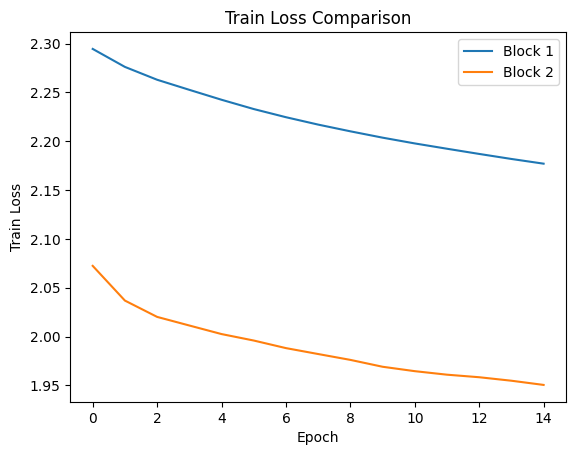

In [60]:
#plotting train loss for each block
import matplotlib.pyplot as plt

for i, block_loss in enumerate(training.block_losses):
    plt.plot(block_loss, label=f'Block {i + 1}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Comparison')
plt.legend()
plt.show()

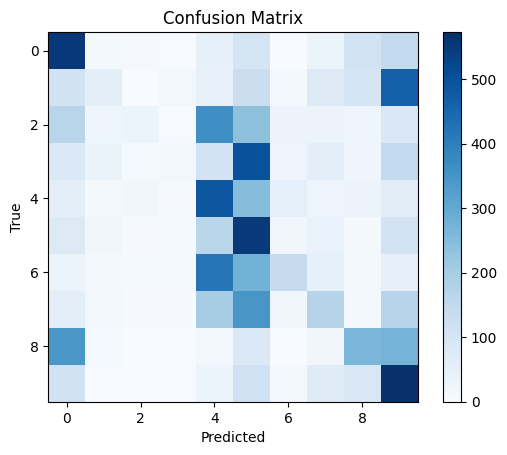

In [61]:
from sklearn.metrics import confusion_matrix

#evaluating model with confusion matrix
def confusionmatrix(model, dataloader):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.imshow(cm, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

#testing
confusionmatrix(model, test_loader)